In [ ]:
%pip install pandas seaborn geopandas bokeh jupyter_bokeh

### Choropleth Map of Biodiversity - County

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from bokeh.palettes import Blues256
from bokeh.io import output_notebook
from bokeh.plotting import output_file, save, figure, show
from bokeh.layouts import layout
from bokeh.models import HoverTool, RangeSlider, CustomJS, RadioButtonGroup
from bokeh.models import GeoJSONDataSource
from bokeh.models import LinearColorMapper, ColorBar

Using the Simpson Diversity Index formula where 0 represents no diversity and 1 represents infinite diversity:

$D = 1 - \sum^R_{i=1} (\dfrac {n_i(n_i-1)}{N(N-1)})$

Formula sourced from: [Libretexts](https://stats.libretexts.org/Bookshelves/Applied_Statistics/Natural_Resources_Biometrics_(Kiernan)/10%3A_Quantitative_Measures_of_Diversity_Site_Similarity_and_Habitat_Suitability/10.01%3A_Introduction__Simpsons_Index_and_Shannon-Weiner_Index#title)

In [3]:
def simpson_diversity(df: pd.DataFrame, spec_col: str, count_col: str) -> float:
  sum = 0
  total_individuals = df[count_col].sum()

  if total_individuals == 1:
    return 0 # Only one species exists, no diversity

  for _, species, count in df.itertuples():
    sum += ((count) * (count - 1)) / (total_individuals * (total_individuals - 1))

  return 1 - sum

Using the Shannon-Wiener Diversity Index

$H' = \frac {N ln \ N -\sum (n_i ln \ n_i)}{N}$

Formula sourced from: [Libretexts](https://stats.libretexts.org/Bookshelves/Applied_Statistics/Natural_Resources_Biometrics_(Kiernan)/10%3A_Quantitative_Measures_of_Diversity_Site_Similarity_and_Habitat_Suitability/10.01%3A_Introduction__Simpsons_Index_and_Shannon-Weiner_Index#title)

In [4]:
def shannon_diversity(df: pd.DataFrame, spec_col: str, count_col: str) -> float:
  sum = 0
  total_individuals = df[count_col].sum()
  for _, species, count in df.itertuples():
    sum += count * np.log(count)

  return ((total_individuals * np.log(total_individuals)) - (sum)) / total_individuals

Test Diversity Index functions

In [6]:
test_df = pd.DataFrame({
  'Species': ['Sugar Maple', 'Beech', 'Yellow Birch'],
  'No. of individuals': [35, 19, 11]
})

# This should output something close to 0.6053
print(simpson_diversity(test_df, 'Species', 'No. of individuals'))

# This should output soomething close to 0.993
print(shannon_diversity(test_df, 'Species', 'No. of individuals'))

0.6052884615384615
0.9934892582483463


<Axes: >

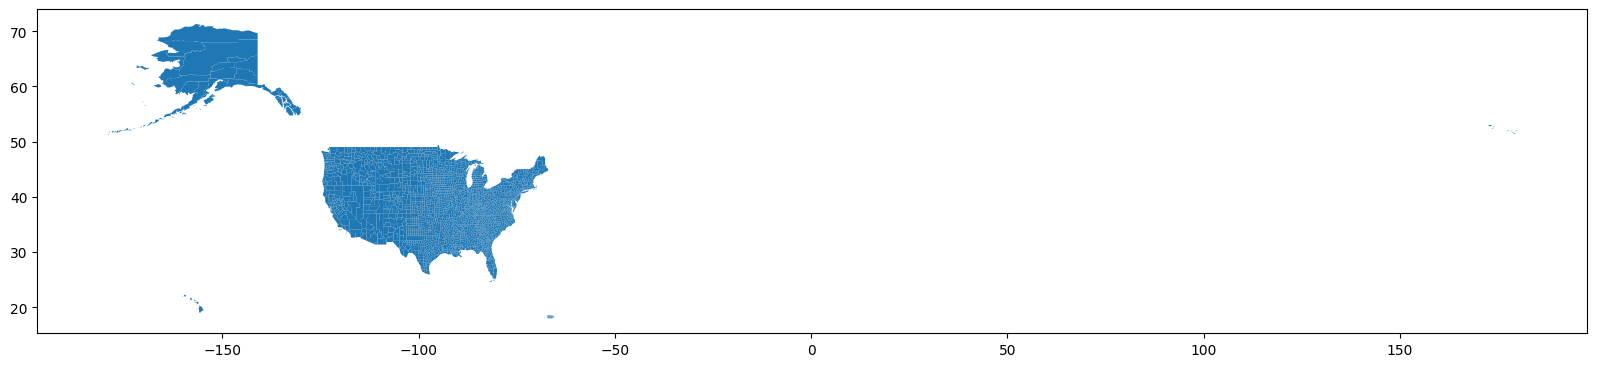

In [7]:
# Import occurrences shapefile

occurrence_gdf = gpd.read_file(Path('../output/occurrences/occurrences.shp'))

# Import USA county map
county_shp = gpd.read_file(Path('../dataset/cb_2023_us_all_20m/cb_2023_us_county_20m/cb_2023_us_county_20m.shp'))

# Update CRS of county map to match `occurrence_gdf`
county_shp = county_shp.to_crs(crs='EPSG:4326') 

county_shp.plot(figsize=(20,20))

<Axes: >

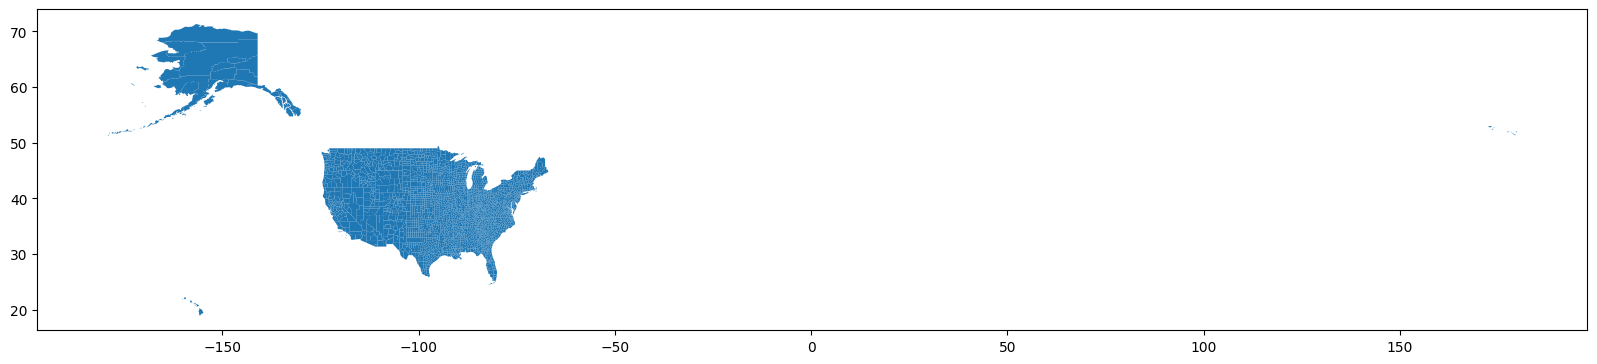

In [8]:
# Remove USA territories, get the 50 states

exclude = ['American Samoa', 'Commonwealth of the Northern Mariana Islands', 'Puerto Rico', 'United States Virgin Islands', 'Guam']

county_shp = county_shp[~county_shp['STATE_NAME'].isin(exclude)]

county_shp.plot(figsize=(20,20))

In [9]:
# Calculate the Simpson and Shannon-Wiener biodiversity for a given `year` for each given `plots` using an `occurrences` dataframe
def plot_biodiversity(plots: gpd.GeoDataFrame, occurrences: gpd.GeoDataFrame, year: int) -> gpd.GeoDataFrame:
  data = {
    f'{year}_simpson': [],
    f'{year}_shannon': []
  }

  year_occurrences = occurrences[occurrences['year'] == year]
  
  for row in plots.itertuples():
    county_occurrences = year_occurrences[row.geometry.contains(year_occurrences['geometry'])]
    if len(county_occurrences) == 0:
      data[f'{year}_simpson'].append(pd.NA)
      data[f'{year}_shannon'].append(pd.NA)
    else:
      data[f'{year}_simpson'].append(
        simpson_diversity(county_occurrences['verbatName'].value_counts().reset_index(), 'verbatName', 'count')
      )
      data[f'{year}_shannon'].append(
        shannon_diversity(county_occurrences['verbatName'].value_counts().reset_index(), 'verbatName', 'count')
      )

  plots[f'{year}_simpson'] = data[f'{year}_simpson']
  plots[f'{year}_shannon'] = data[f'{year}_shannon']

  return plots

In [17]:
# Load counties dataframe from disk if it exists

default_years = (2004, 2024)
county_chart_gdf = None
years = sorted(occurrence_gdf['year'].unique())

try:
  counties_dataset = gpd.read_file(Path('../output/counties/counties.geojson')).replace({'<NA>': np.nan})
  # Convert columns to numeric types if possible
  for column in counties_dataset.columns:
    try:
      counties_dataset[column] = pd.to_numeric(counties_dataset[column])
    except:
      None

  county_chart_gdf = counties_dataset.fillna(value=np.nan)
except:
  None # File likely does not exist, do nothing

# Otherwise, regenerate the dataset
if county_chart_gdf is None:
  county_chart_gdf = county_shp.copy()

  for year in years:
    county_chart_gdf = plot_biodiversity(county_chart_gdf, occurrence_gdf, year)

  # Create default data for the first draw of the Bokeh plot

  filter_simpson_years = []
  for year in range(default_years[0], default_years[1] + 1):
    if year in years:
      filter_simpson_years.append(f'{year}_simpson')

  filter_shannon_years = []
  for year in range(default_years[0], default_years[1] + 1):
    if year in years:
      filter_shannon_years.append(f'{year}_shannon')

  county_chart_gdf['simpson_biodiversity'] = county_chart_gdf[filter_simpson_years].mean(axis=1)
  county_chart_gdf['shannon_biodiversity'] = county_chart_gdf[filter_shannon_years].mean(axis=1)

  # Save to a file
  county_chart_gdf.to_file(Path(f'../output/counties/counties.geojson'), driver='GeoJSON')

county_chart_gdf

STATEFP  COUNTYFP  COUNTYNS         GEOIDFQ  GEOID        NAME  \
0          13        27    345518  0500000US13027  13027      Brooks   
1          31        95    835869  0500000US31095  31095   Jefferson   
2          51       683   1498430  0500000US51683  51683    Manassas   
3          56        21   1605075  0500000US56021  56021     Laramie   
4          13       135   1688166  0500000US13135  13135    Gwinnett   
...       ...       ...       ...             ...    ...         ...   
3139       39        87   1074056  0500000US39087  39087    Lawrence   
3140       33        15    873181  0500000US33015  33015  Rockingham   
3141       51       191   1498359  0500000US51191  51191  Washington   
3142       48       105   1383838  0500000US48105  48105    Crockett   
3143       37       155   1026130  0500000US37155  37155     Robeson   

               NAMELSAD STUSPS      STATE_NAME LSAD  ...  2021_shannon  \
0         Brooks County     GA         Georgia   06  ...           NaN   
1      Jefferson County     NE        Nebraska   06  ...           NaN   
2         Manassas city     VA        Virginia   25  ...           NaN   
3        Laramie County     WY         Wyoming   06  ...           NaN   
4       Gwinnett County     GA         Georgia   06  ...           NaN   
...                 ...    ...             ...  ...  ...           ...   
3139    Lawrence County     OH            Ohio   06  ...           NaN   
3140  Rockingham County     NH   New Hampshire   06  ...           NaN   
3141  Washington County     VA        Virginia   06  ...           NaN   
3142    Crockett County     TX           Texas   06  ...           NaN   
3143     Robeson County     NC  North Carolina   06  ...           NaN   

      2022_simpson  2022_shannon  2023_simpson  2023_shannon  2024_simpson  \
0              NaN           NaN           NaN           NaN           NaN   
1              NaN           NaN           NaN           NaN           NaN   
2              NaN           NaN           NaN           NaN           NaN   
3              NaN           NaN           NaN           NaN           NaN   
4              NaN           NaN           NaN           NaN           NaN   
...            ...           ...           ...           ...           ...   
3139           NaN           NaN           NaN           NaN           NaN   
3140           NaN           NaN           NaN           NaN           NaN   
3141           NaN           NaN           NaN           NaN           NaN   
3142           NaN           NaN           NaN           NaN           NaN   
3143           NaN           NaN           NaN           NaN           NaN   

      2024_shannon  simpson_biodiversity  shannon_biodiversity  \
0              NaN                   NaN                   NaN   
1              NaN                   NaN                   NaN   
2              NaN                   NaN                   NaN   
3              NaN                   NaN                   NaN   
4              NaN              0.875817              1.985053   
...            ...                   ...                   ...   
3139           NaN              1.000000              1.098612   
3140           NaN                   NaN                   NaN   
3141           NaN              0.666667              0.636514   
3142           NaN                   NaN                   NaN   
3143           NaN                   NaN                   NaN   

                                               geometry  
0     POLYGON ((-83.73616 31.03768, -83.57396 31.033...  
1     POLYGON ((-97.36869 40.35039, -96.91606 40.349...  
2     POLYGON ((-77.52666 38.7332, -77.49545 38.7706...  
3     POLYGON ((-105.27824 41.65666, -104.65334 41.6...  
4     POLYGON ((-84.27117 33.9598, -84.26266 33.9871...  
...                                                 ...  
3139  POLYGON ((-82.81154 38.57237, -82.74038 38.597...  
3140  POLYGON ((-71.4423 42.8904, -71.37544 42.93932...  


In [18]:
county_chart_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
output_notebook()

Loading BokehJS ...

In [ ]:
# Reproject `county_chart_gdf` to use 360 degrees and disregard the antimeridian
# This prevents Alaska's Aleutian Islands from being cut off
county_chart_gdf = county_chart_gdf.to_crs({'init': 'epsg:4326', 'lon_wrap': 180})

In [23]:
# Create the Bokeh chart

from bokeh.layouts import layout

patch_colors = []
palette = list(reversed(Blues256)) # light for low values, dark for high values
for _, row in county_chart_gdf.iterrows():
    try:
        i = int(row['simpson_biodiversity'] * 255)
        patch_colors.append(palette[i])
    except ValueError: # Value is NaN
        patch_colors.append(palette[0])

### Uncomment to see Shannon-Wiener colors on the first draw
# shannon_max = county_chart_gdf['shannon_biodiversity'].max()
# for _, row in county_chart_gdf.iterrows():
#     try:
#         proportion = row['shannon_biodiversity'] / shannon_max
#         i = int(proportion * 255)
#         patch_colors.append(palette[i])
#     except ValueError: # Value is NaN
#         patch_colors.append(palette[0])

county_chart_gdf['color'] = patch_colors

source = GeoJSONDataSource(geojson=county_chart_gdf.to_json())

p = figure(
    title="Choropleth Map of USA Biodiversity by County",
    toolbar_location='left',
    width=800,
    height=800,
)

p.patches('xs', 'ys', source=source, fill_color='color', fill_alpha=0.7, line_color = "black", line_width = 0.5)

color_mapper = LinearColorMapper(palette=list(reversed(Blues256)))
color_bar = ColorBar(
    color_mapper=color_mapper, 
    padding=5, 
    bar_line_color='black', 
    title='Increasing Biodiversity ------->',
)
p.add_layout(color_bar, 'right')

p.add_tools(HoverTool(tooltips=[
    ("County", "@NAMELSAD"),
    ("State", "@STATE_NAME"),
    ("Simpson Index", "@simpson_biodiversity"),
    ("Shannon-Wiener Index", "@shannon_biodiversity"),
], point_policy="follow_mouse"))

range_js = """
    var data = source.data;
    var palette = palette;

    // cb_obj.value[0] // Start Year

    // cb_obj.value[1] // End Year

    var years = [];

    // Get valid years between the range values
    for (var i = 0; i <= cb_obj.value[1] - cb_obj.value[0]; i++) {
        let year = cb_obj.value[0] + i;

        // We only need to check this for one index
        if (`${year}_simpson` in data) {
            years.push(year);
        }
    }

    // Recalculate biodiversity (Get mean of all valid years)
    // Other indices have the same length as the array used here
    for (var i = 0; i < data.simpson_biodiversity.length; i++) {
        // Get average of values for this row
        let simpson = 0;
        let shannon = 0;

        let valid_simpson_count = 0;
        let valid_shannon_count = 0;

        for (var j = 0; j < years.length; j++) {
            let year = years[j];

            if (!isNaN(data[`${year}_simpson`][i])) {
                simpson += data[`${year}_simpson`][i];
                valid_simpson_count += 1;
            }
            if (!isNaN(data[`${year}_shannon`][i])) {
                shannon += data[`${year}_shannon`][i];
                valid_shannon_count += 1;
            }
        }

        data.simpson_biodiversity[i] = simpson / valid_simpson_count;
        data.shannon_biodiversity[i] = shannon / valid_shannon_count;
    }

    // Update patch colors

    // Simpson Index
    if (btn.active == 0) {
        // Update Colors

        for (var i = 0; i < data.color.length; i++) {
            if (isNaN(data.simpson_biodiversity[i])) {
                data.color[i] = palette[0];
            }
            else {
                data.color[i] = palette[Math.floor(data.simpson_biodiversity[i] * 255)];
            }
        }
    }

    // Shannon-Wiener Index
    if (btn.active == 1) {
        // Update Colors
        
        // Get max Shannon-Wiener Index value
        let shannon_max = 0

        for (var i = 0; i < data.shannon_biodiversity.length; i++) {
            if (!isNaN(data.shannon_biodiversity[i])) {
                if (data.shannon_biodiversity[i] > shannon_max) {
                    shannon_max = data.shannon_biodiversity[i]
                }
            }
        }
        
        for (var i = 0; i < data.color.length; i++) {
            if (isNaN(data.shannon_biodiversity[i])) {
                data.color[i] = palette[0];
            }
            else {
                let proportion = data.shannon_biodiversity[i] / shannon_max
                data.color[i] = palette[Math.floor(proportion * 255)];
            }
        }
    }

    source.change.emit();
"""

button_js = """
    var data = source.data;
    var palette = palette;

    // Simpson Index
    if (btn.active == 0) {
        // Update Colors

        for (var i = 0; i < data.color.length; i++) {
            if (isNaN(data.simpson_biodiversity[i])) {
                data.color[i] = palette[0];
            }
            else {
                data.color[i] = palette[Math.floor(data.simpson_biodiversity[i] * 255)];
            }
        }
    }

    // Shannon-Wiener Index
    if (btn.active == 1) {
        // Update Colors
        
        // Get max Shannon-Wiener Index value
        let shannon_max = 0

        for (var i = 0; i < data.shannon_biodiversity.length; i++) {
            if (!isNaN(data.shannon_biodiversity[i])) {
                if (data.shannon_biodiversity[i] > shannon_max) {
                    shannon_max = data.shannon_biodiversity[i]
                }
            }
        }
        
        for (var i = 0; i < data.color.length; i++) {
            if (isNaN(data.shannon_biodiversity[i])) {
                data.color[i] = palette[0];
            }
            else {
                let proportion = data.shannon_biodiversity[i] / shannon_max
                data.color[i] = palette[Math.floor(proportion * 255)];
            }
        }
    }

    source.change.emit();
"""

labels = ['Simpson Index', 'Shannon-Wiener Index']

radio_buttons = RadioButtonGroup(labels=labels, active=0)

range_slider = RangeSlider(title="Years", start=years[0], end=years[-1], value=default_years, step=1)

range_slider.js_on_change('value', CustomJS(args=dict(source=source, palette=palette, btn=radio_buttons), code = range_js))

radio_buttons.js_on_event("button_click", CustomJS(args=dict(source=source, palette=palette, btn=radio_buttons), code=button_js))

layout = layout(
    [range_slider, radio_buttons],
    [p]
)

show(layout)

In [ ]:
# Save plot to a file
output_file(filename=Path('../charts/biodiversity_county.html'), title='Choropleth Map of USA Biodiversity by County')
save(layout)